In [273]:
import pandas as pd
import numpy as np

import autorootcwd  # noqa
from hamilton import driver

from src.data import data_pipeline
from src.data.pydantic_models import BearingDataset
from functools import partial
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    GroupKFold,
    cross_validate,
    cross_val_predict,
)
from scipy.stats import randint, loguniform
import logging
import random
from src.utils.add_signal_data import add_signal_data_cwru
from typing import Literal, Tuple
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score

In [274]:
from src.data.data_splits import (split_cwru_proposed, cwru_optimization_split)
from itertools import combinations, product
import random

In [275]:
def split_cwru_proposed(
    df: pd.DataFrame,
    normal_train_side: Literal["DE", "FE"],
    random_state: int = 42,
    HP0_ontest: bool = False,
    HP0_ontrain: bool = False,
    include_normal_config_on_test: bool = False,
    test_size: float = 1 / 3,
) -> Tuple[pd.DataFrame, None, pd.DataFrame]:
    """Prepare CWRU dataset for model training and testing.

    - LT Split (Fault location and type): stratified, (Size): random
    """
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    df["fault_type"] = df["fault_type"].str.replace("OR@3", "OR")
    df["fault_type"] = df["fault_type"].str.replace("OR@6", "OR")
    df["group"] = (
        df["fault_location"].astype(str)
        + "_"
        + df["fault_type"].astype(str)
        + "_"
        + df["fault_size"].astype(str)
    )

    # We will not use all 411 signals from CWRU, this CSV filter to only used (144 signals)
    df_filtered_ids = pd.read_csv("data/splits/cwru/filtered_cwru.csv")
    df = df[df["waveform_id"].isin(df_filtered_ids["waveform_id"].tolist())]

    test_ids_optimization = []

    for optimization_fold in range(1, 4):
        for train_side in ["DE", "FE"]:
            test_ids = pd.read_csv(
                f"data/splits/cwru/fold_{optimization_fold}/test_{train_side}.csv"
            )["waveform_id"].tolist()
            test_ids_optimization.append(test_ids)

    # For each location-type pair, split into train and test by randomly selecting a size
    for enum, (_group, df_group) in enumerate(df.groupby(["fault_location", "fault_type"])):
        gss = GroupShuffleSplit(
            n_splits=1, test_size=test_size, random_state=random_state + enum * 1000
        )
        df_train_idx, df_test_idx = next(gss.split(df_group, groups=df_group.group))
        df_train = pd.concat([df_train, df_group.iloc[df_train_idx]], ignore_index=True)
        df_test = pd.concat([df_test, df_group.iloc[df_test_idx]], ignore_index=True)

        print(df_train.shape, df_test.shape)

    if normal_train_side == "DE":
        df_train = df_train[
            ~(
                (df_train["signal_location"] == "FE")
                & (df_train["fault_location"] == "DE")
            )
        ]
        df_test = df_test[
            ~(
                (df_test["signal_location"] == "DE")
                & (df_test["fault_location"] == "FE")
            )
        ]
    elif normal_train_side == "FE":
        df_train = df_train[
            ~(
                (df_train["signal_location"] == "DE")
                & (df_train["fault_location"] == "FE")
            )
        ]
        df_test = df_test[
            ~(
                (df_test["signal_location"] == "FE")
                & (df_test["fault_location"] == "DE")
            )
        ]
    elif normal_train_side == "both":
        pass

    # Check if the test set is equal to some of the optimization test sets and if so, create a new test set
    test_waveform_ids = set(df_test["waveform_id"].tolist())

    # Function to check if test set is equal to any optimization set
    def check_equality(test_ids, opt_ids_list):
        for i, opt_ids in enumerate(opt_ids_list):
            opt_ids_set = set(opt_ids)
            if test_ids == opt_ids_set:
                return True
        return False

    # Initial check before any additional splits
    is_equal = check_equality(test_waveform_ids, test_ids_optimization)
    attempt = 0

    while is_equal:
        attempt += 1
        new_random_state = random_state + attempt * 100

        # Repeat the splitting process with a new random seed
        df_train = pd.DataFrame()
        df_test = pd.DataFrame()

        for enum, (_group, df_group) in enumerate(df.groupby(["fault_location", "fault_type"])):
            gss = GroupShuffleSplit(
                n_splits=1, test_size=test_size, random_state=new_random_state + enum * 1000
            )
            df_train_idx, df_test_idx = next(gss.split(df_group, groups=df_group.group))
            df_train = pd.concat(
                [df_train, df_group.iloc[df_train_idx]], ignore_index=True
            )
            df_test = pd.concat(
                [df_test, df_group.iloc[df_test_idx]], ignore_index=True
            )

        # Re-apply the filtering based on normal_train_side
        if normal_train_side == "DE":
            df_train = df_train[
                ~(
                    (df_train["signal_location"] == "FE")
                    & (df_train["fault_location"] == "DE")
                )
            ]
            df_test = df_test[
                ~(
                    (df_test["signal_location"] == "DE")
                    & (df_test["fault_location"] == "FE")
                )
            ]
        elif normal_train_side == "FE":
            df_train = df_train[
                ~(
                    (df_train["signal_location"] == "DE")
                    & (df_train["fault_location"] == "FE")
                )
            ]
            df_test = df_test[
                ~(
                    (df_test["signal_location"] == "FE")
                    & (df_test["fault_location"] == "DE")
                )
            ]
        elif normal_train_side == "both":
            pass

        # Check equality again
        test_waveform_ids = set(df_test["waveform_id"].tolist())
        is_equal = check_equality(test_waveform_ids, test_ids_optimization)

    #df_train = df_train.drop(columns=["group"])
    #df_test = df_test.drop(columns=["group"])

    if not HP0_ontest:
        print("Removing HP0 from test set")
        df_test = df_test[~df_test["load"].isin([0])]
    else:
        print("Keeping HP0 in test set")
    if not HP0_ontrain:
        print("Removing HP0 from train set")
        df_train = df_train[~df_train["load"].isin([0])]
    else:
        print("Keeping HP0 in train set")

    if include_normal_config_on_test:
        normal_df = pd.read_csv("data/splits/cwru/normal_signals.csv")
        df_test = pd.concat([df_test, normal_df], ignore_index=True)
    print("Test set size: ", df_test.shape[0])

    df_val = df_test
    return df_train, df_val, df_test

In [253]:
def get_cv_splits(
    metadata_df: pd.DataFrame,
    run: int,
    train_side: str = "DE",
    pct = 1,
    test_size = 1 / 3
):
    
    no_duplicate = metadata_df.drop_duplicates(subset=["waveform_id"]).copy()

    train, _ , test = split_cwru_proposed(
        df=no_duplicate,
        random_state=run,
        HP0_ontrain= True,
        HP0_ontest= True,
        normal_train_side= train_side,
        test_size = test_size,
    )
    
    train_idx = train.index.tolist()
    test_idx = test.index.tolist()

    train_df = metadata_df[metadata_df["waveform_id"].isin(train["waveform_id"])]
    # for each waveform_id, select pct of the samples
    if pct < 1:
        train_df = train_df.groupby("waveform_id").apply(lambda x: x.sample(frac=pct, random_state=42)).drop(columns=['waveform_id']).reset_index()
        train_idx = train_df.level_1.values.tolist()
    elif pct > 1:
        # repeat samples if pct > 1
        train_df = train_df.groupby("waveform_id_seg").apply(lambda x: x.sample(n=int(pct), replace=True, random_state=42)).drop(columns=['waveform_id_seg']).reset_index()
        train_idx = train_df.level_1.values.tolist()
    else:
        train_idx = train_df.index.tolist()
    
    test_df = metadata_df[metadata_df["waveform_id"].isin(test["waveform_id"])]
    test_idx = test_df.index.tolist()

    cv = (train_idx, test_idx)

    return cv

def get_val_cv_splits(
    metadata_df,
    test_fold,
    train_side,
    withHP0: bool = True,
    pct = 1
    ):

    no_duplicate = metadata_df.drop_duplicates(subset=["waveform_id"]).copy()


    train, _, test = cwru_optimization_split(
        df=no_duplicate,
        test_fold=test_fold,
        random_state=42,
        withHP0=withHP0,
        train_side=train_side
        )
    
    train_df = metadata_df[metadata_df["waveform_id"].isin(train["waveform_id"])]
    test_df = metadata_df[metadata_df["waveform_id"].isin(test["waveform_id"])]

    if pct < 1:
        train_df = train_df.groupby("waveform_id").apply(lambda x: x.sample(frac=pct, random_state=42)).drop(columns=['waveform_id']).reset_index()
        train_idx = train_df.level_1.values.tolist()
    else:
        train_idx = train_df.index.tolist()

    test_idx = test_df.index.tolist()

    cv = (train_idx, test_idx)

    return cv

In [276]:
metadata = pd.read_pickle("/data/bearing_datasets/cwru/processed/files_metadata.bz2")
features = pd.read_pickle("data/features/cwru_features_segmented.pkl")

In [277]:
metadata.head()

,waveform_id,fault_location,load,rpm,fault_type,fault_size,signal_location,fs,duration,bpfo,bpfi,bsf,ftf,inner,outer,ball,multiclass_label
0,OR@3_7_DE_DE_48_3HP,DE,3,1730,OR@3,7,DE,48000,10.129667,3.5848,5.4152,4.7135,0.39828,0,1,0,2
1,B_21_FE_FE_12_3HP,FE,3,1730,B,21,FE,12000,10.066750,3.0530,4.9469,3.9874,0.38170,0,0,1,3
2,B_7_DE_BA_12_3HP,DE,3,1730,B,7,BA,12000,10.129667,NaN,NaN,NaN,NaN,0,0,0,0
3,OR@3_7_FE_FE_12_3HP,FE,3,1730,OR@3,7,FE,12000,10.143250,3.0530,4.9469,3.9874,0.38170,0,1,0,2
4,OR@6_14_DE_FE_12_3HP,DE,3,1730,OR@6,14,FE,12000,10.165917,3.0530,4.9469,3.9874,0.38170,0,0,0,0


In [278]:
df = features.merge(metadata, on="waveform_id", how="left")

In [279]:
#val_cvs = [get_val_cv_splits(
#    metadata_df=df,
#    test_fold=run,
#    train_side=side, pct=1)
# for (run, side) in product(
#    range(1,4), ["FE", "DE"])]

val_cvs = [get_cv_splits(
    metadata_df=df,
    run=run,
    train_side=side, pct=1, test_size = 2 / 3)
 for (run, side) in product(
    range(1,4), ["FE", "DE"])]

cvs = [get_cv_splits(
    metadata_df=df,
    run=run,
    train_side=side, pct=1, test_size = 2 / 3)
 for (run, side) in product(
    range(4,54), ["FE", "DE"])]

(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  72
(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  72
(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  72
(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  72
(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  72
(8, 44) (16, 44)
(16, 44) (32, 44)
(24, 44) (48, 44)
(32, 44) (64, 44)
(40, 44) (80, 44)
(48, 44) (96, 44)
Keeping HP0 in tes

In [280]:
len(cvs[0][0])

720

In [281]:
len(val_cvs[0][0])

720

In [282]:
df.iloc[cvs[0][1]].waveform_id_seg.nunique(), df.iloc[cvs[0][0]].waveform_id_seg.value_counts()

(1440,
 waveform_id_seg
 B_7_DE_FE_12_1HP_7650    1
 B_7_DE_FE_12_1HP_7649    1
 B_7_DE_FE_12_1HP_7648    1
 B_7_DE_FE_12_1HP_7647    1
 B_7_DE_DE_12_1HP_7286    1
                         ..
 B_21_FE_FE_12_3HP_25     1
 B_21_FE_FE_12_3HP_24     1
 B_21_FE_FE_12_3HP_23     1
 B_21_FE_FE_12_3HP_22     1
 B_21_FE_FE_12_3HP_21     1
 Name: count, Length: 720, dtype: int64)

In [283]:
val_train0, _, val_test0 = cwru_optimization_split(
    df=metadata,
    test_fold=1,
    train_side="FE",)

In [284]:
val_train0

,waveform_id,fault_location,load,rpm,fault_type,fault_size,signal_location,fs,duration,bpfo,bpfi,bsf,ftf,inner,outer,ball,multiclass_label
0,B_21_DE_FE_12_3HP,DE,3,1730,B,21,FE,12000,10.178000,3.0530,4.9469,3.9874,0.38170,0,0,0,0
1,B_14_FE_FE_12_3HP,FE,3,1730,B,14,FE,12000,10.097333,3.0530,4.9469,3.9874,0.38170,0,0,1,3
2,OR@6_7_DE_DE_12_3HP,DE,3,1730,OR@6,7,DE,12000,10.214250,3.5848,5.4152,4.7135,0.39828,0,1,0,2
3,OR@6_21_DE_FE_12_3HP,DE,3,1730,OR@6,21,FE,12000,10.165917,3.0530,4.9469,3.9874,0.38170,0,0,0,0
4,OR@6_7_DE_FE_12_3HP,DE,3,1730,OR@6,7,FE,12000,10.214250,3.0530,4.9469,3.9874,0.38170,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,B_7_DE_DE_12_1HP,DE,1,1772,B,7,DE,12000,10.117500,3.5848,5.4152,4.7135,0.39828,0,0,1,3
68,OR@6_21_DE_DE_12_1HP,DE,1,1772,OR@6,21,DE,12000,10.165917,3.5848,5.4152,4.7135,0.39828,0,1,0,2
69,IR_14_DE_FE_12_1HP,DE,1,1772,IR,14,FE,12000,10.153833,3.0530,4.9469,3.9874,0.38170,0,0,0,0
70,B_7_DE_FE_12_1HP,DE,1,1772,B,7,FE,12000,10.117500,3.0530,4.9469,3.9874,0.38170,0,0,0,0


In [206]:
train0, _, test0 = split_cwru_proposed(
    df=metadata,
    random_state=4,
    HP0_ontrain=True,
    HP0_ontest=True,
    normal_train_side="FE"
)

(16, 18) (8, 18)
(32, 18) (16, 18)
(48, 18) (24, 18)
(64, 18) (32, 18)
(80, 18) (40, 18)
(96, 18) (48, 18)
Keeping HP0 in test set
Keeping HP0 in train set
Test set size:  36


In [285]:
features = [ 'acceleration/rms/global', 'acceleration/pk-pk/global',
       'acceleration/kurt/global', 'acceleration/skewness/global',
       'acceleration/fc/global',
       'envelope/spectralPeak/1.0x-bpfo/500-6000',
       'envelope/spectralPeak/2.0x-bpfo/500-6000',
       'envelope/spectralPeak/3.0x-bpfo/500-6000',
       'envelope/spectralPeak/4.0x-bpfo/500-6000',
       'envelope/spectralPeak/5.0x-bpfo/500-6000',
       'envelope/spectralPeak/1.0x-bpfi/500-6000',
       'envelope/spectralPeak/2.0x-bpfi/500-6000',
       'envelope/spectralPeak/3.0x-bpfi/500-6000',
       'envelope/spectralPeak/4.0x-bpfi/500-6000',
       'envelope/spectralPeak/5.0x-bpfi/500-6000',
       'envelope/spectralPeak/1.0x-bsf/500-6000',
       'envelope/spectralPeak/2.0x-bsf/500-6000',
       'envelope/spectralPeak/3.0x-bsf/500-6000',
       'envelope/spectralPeak/4.0x-bsf/500-6000',
       'envelope/spectralPeak/5.0x-bsf/500-6000']

pfrs = ['envelope/1.0x-pfr-bpfo/500-6000', 'envelope/2.0x-pfr-bpfo/500-6000',
       'envelope/3.0x-pfr-bpfo/500-6000', 'envelope/4.0x-pfr-bpfo/500-6000',
       'envelope/5.0x-pfr-bpfo/500-6000', 'envelope/1.0x-pfr-bpfi/500-6000',
       'envelope/2.0x-pfr-bpfi/500-6000', 'envelope/3.0x-pfr-bpfi/500-6000',
       'envelope/4.0x-pfr-bpfi/500-6000', 'envelope/5.0x-pfr-bpfi/500-6000',
       'envelope/1.0x-pfr-bsf/500-6000', 'envelope/2.0x-pfr-bsf/500-6000',
       'envelope/3.0x-pfr-bsf/500-6000', 'envelope/4.0x-pfr-bsf/500-6000',
       'envelope/5.0x-pfr-bsf/500-6000']

In [286]:
X = df[features].copy()
y = df[['inner', 'outer', 'ball']].copy()

#X_pfrs = df[pfrs].copy()

# Features (segmented)

## RF

In [287]:
random_search = RandomizedSearchCV(
    estimator=MultiOutputClassifier(RandomForestClassifier()),
    param_distributions={
        "estimator__n_estimators": [200],
        "estimator__max_features": ["sqrt", "log2"],
        "estimator__criterion": ["gini", "entropy", "log_loss"],
        "estimator__max_depth": randint(low=2, high=60),
        "estimator__min_samples_split": randint(low=2, high=20),
        "estimator__min_samples_leaf": randint(low=1, high=20),
        "estimator__ccp_alpha": loguniform(1e-5, 1),
    },
    n_iter=250,
    cv=val_cvs,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1,
)

random_search.fit(X, y)

Fitting 6 folds for each of 250 candidates, totalling 1500 fits
[CV] END estimator__ccp_alpha=0.001303671163830941, estimator__criterion=log_loss, estimator__max_depth=33, estimator__max_features=sqrt, estimator__min_samples_leaf=8, estimator__min_samples_split=17, estimator__n_estimators=200; total time=   1.1s
[CV] END estimator__ccp_alpha=0.11576246788084651, estimator__criterion=gini, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=15, estimator__min_samples_split=16, estimator__n_estimators=200; total time=   1.0s
[CV] END estimator__ccp_alpha=0.11576246788084651, estimator__criterion=gini, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=15, estimator__min_samples_split=16, estimator__n_estimators=200; total time=   0.9s
[CV] END estimator__ccp_alpha=0.11576246788084651, estimator__criterion=gini, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=15, estimator__min_samples_split=

RandomizedSearchCV(cv=[([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
                         48, 49, ...],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, ...]),
                       ([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                         94, 95, 96, 97, 98, 99, 160, 161, 162, 163, 164, 165,
                         166, 167, 168, 169, ...],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...
                                        'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5350226650>,
                                        'estimator__max_features': ['sqrt',
                                                                    'log2'],
                                        'estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f546762fb10>,
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f546797a5d0>,
                                        'estimator__n_estimators': [200]},
                   scoring='roc_auc', verbose=2)

In [288]:
results = pd.DataFrame(random_search.cv_results_).sort_values(by="rank_test_score")

In [289]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__ccp_alpha,param_estimator__criterion,param_estimator__max_depth,param_estimator__max_features,param_estimator__min_samples_leaf,param_estimator__min_samples_split,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
1,1.019935,0.025544,0.043024,0.003586,0.116276,log_loss,56,log2,17,19,...,"{'estimator__ccp_alpha': 0.11627578116552983, ...",0.852753,0.839233,0.824003,0.793667,0.859072,0.785998,0.825788,0.027791,1
26,1.039296,0.030319,0.043287,0.001873,0.195359,log_loss,20,log2,13,13,...,"{'estimator__ccp_alpha': 0.19535856747233912, ...",0.851025,0.820937,0.807013,0.807942,0.868218,0.792445,0.824597,0.026567,2
57,1.060125,0.029561,0.043446,0.000362,0.109152,log_loss,47,log2,6,18,...,"{'estimator__ccp_alpha': 0.10915165540203618, ...",0.851793,0.839080,0.823090,0.799853,0.859560,0.773771,0.824524,0.029915,3
71,0.959582,0.057696,0.045393,0.001600,0.007542,entropy,2,sqrt,7,7,...,"{'estimator__ccp_alpha': 0.007542183938672127,...",0.851664,0.821893,0.825208,0.820559,0.855087,0.768875,0.823881,0.028249,4
135,1.044617,0.031926,0.043623,0.000856,0.141622,entropy,59,sqrt,12,6,...,"{'estimator__ccp_alpha': 0.1416215878908001, '...",0.848910,0.835543,0.821429,0.802922,0.857127,0.776717,0.823774,0.027500,5
164,1.052466,0.034595,0.044264,0.001230,0.144908,log_loss,12,log2,10,5,...,"{'estimator__ccp_alpha': 0.1449082835935594, '...",0.841470,0.830079,0.824165,0.799471,0.860421,0.782380,0.822998,0.025809,6
218,1.053067,0.031323,0.043548,0.000855,0.140681,log_loss,41,log2,11,19,...,"{'estimator__ccp_alpha': 0.14068076859186088, ...",0.848900,0.825551,0.800340,0.809838,0.864385,0.783370,0.822064,0.027815,7
184,1.033626,0.033110,0.045674,0.001104,0.091549,log_loss,18,log2,15,19,...,"{'estimator__ccp_alpha': 0.09154903220722009, ...",0.861278,0.827161,0.811596,0.804932,0.855109,0.771361,0.821906,0.030631,8
93,1.057514,0.035925,0.043348,0.001709,0.166867,entropy,41,sqrt,6,9,...,"{'estimator__ccp_alpha': 0.16686668027615317, ...",0.851686,0.838819,0.785946,0.806309,0.858730,0.789608,0.821850,0.029179,9
122,1.026506,0.030155,0.042657,0.001108,0.187406,entropy,17,log2,19,7,...,"{'estimator__ccp_alpha': 0.1874056967430475, '...",0.854619,0.824499,0.792084,0.799499,0.866876,0.793031,0.821768,0.029789,10


In [290]:
best_params = results.iloc[0]["params"]

In [291]:
best_params.values()

dict_values([np.float64(0.11627578116552983), 'log_loss', 56, 'log2', 17, 19, 200])

In [292]:
keys = []
for i in best_params.keys():
    keys.append(i.replace("estimator__", ""))

In [293]:
best_params = {k: i for (k,i) in zip(keys, best_params.values())}

In [294]:
best_params

{'ccp_alpha': np.float64(0.11627578116552983),
 'criterion': 'log_loss',
 'max_depth': 56,
 'max_features': 'log2',
 'min_samples_leaf': 17,
 'min_samples_split': 19,
 'n_estimators': 200}

In [295]:

aucs = []
for cv in cvs:

    X_train = X.iloc[cv[0]]
    X_test = X.iloc[cv[1]]

    y_train = y.iloc[cv[0]]
    y_test = y.iloc[cv[1]]

    model = MultiOutputClassifier(RandomForestClassifier(random_state=42, **best_params), n_jobs=-1)

    model.fit(X_train, y_train)
    y_probas = model.predict_proba(X_test)
    proba_outer = y_probas[1][:, 1]
    proba_inner = y_probas[0][:, 1]
    proba_ball = y_probas[2][:, 1]

    auroc_outer = roc_auc_score(y_test["outer"], proba_outer)
    auroc_inner = roc_auc_score(y_test["inner"], proba_inner)
    auroc_ball = roc_auc_score(y_test["ball"], proba_ball)

    macro_auc = np.mean([auroc_outer, auroc_inner, auroc_ball])
    print(f"Macro AUC: {macro_auc:.4f} | Outer AUC: {auroc_outer:.4f} | Inner AUC: {auroc_inner:.4f} | Ball AUC: {auroc_ball:.4f}")
    aucs.append([macro_auc, auroc_outer, auroc_inner, auroc_ball])

Macro AUC: 0.7852 | Outer AUC: 0.6467 | Inner AUC: 0.9128 | Ball AUC: 0.7961
Macro AUC: 0.8019 | Outer AUC: 0.6871 | Inner AUC: 0.9724 | Ball AUC: 0.7463
Macro AUC: 0.7081 | Outer AUC: 0.6860 | Inner AUC: 0.7649 | Ball AUC: 0.6733
Macro AUC: 0.7265 | Outer AUC: 0.6441 | Inner AUC: 0.7386 | Ball AUC: 0.7970
Macro AUC: 0.9048 | Outer AUC: 0.8979 | Inner AUC: 0.9717 | Ball AUC: 0.8449
Macro AUC: 0.8474 | Outer AUC: 0.8736 | Inner AUC: 0.8817 | Ball AUC: 0.7870
Macro AUC: 0.7650 | Outer AUC: 0.7848 | Inner AUC: 0.7599 | Ball AUC: 0.7504
Macro AUC: 0.8397 | Outer AUC: 0.7788 | Inner AUC: 0.8847 | Ball AUC: 0.8556
Macro AUC: 0.7766 | Outer AUC: 0.6795 | Inner AUC: 0.8535 | Ball AUC: 0.7967
Macro AUC: 0.7919 | Outer AUC: 0.7084 | Inner AUC: 0.7768 | Ball AUC: 0.8904
Macro AUC: 0.7944 | Outer AUC: 0.6861 | Inner AUC: 0.8905 | Ball AUC: 0.8067
Macro AUC: 0.7424 | Outer AUC: 0.7155 | Inner AUC: 0.8817 | Ball AUC: 0.6301
Macro AUC: 0.8407 | Outer AUC: 0.8220 | Inner AUC: 0.9216 | Ball AUC: 0.7784

In [296]:
macro_aucs = [i[0] for i in aucs]
np.mean(macro_aucs), np.std(macro_aucs)

(np.float64(0.7824471726190477), np.float64(0.04840108694035889))

In [68]:
df.multiclass_label = df.multiclass_label.apply(lambda x: "Normal" if x==0 else "Inner" if x==1 else "Outer" if x==2 else "Ball")

In [24]:
df_ex = df.copy()
cv_ex = cvs[0]
df_ex.loc[cv_ex[0], "set"] = "Train"
df_ex.loc[cv_ex[1], "set"] = "Test"

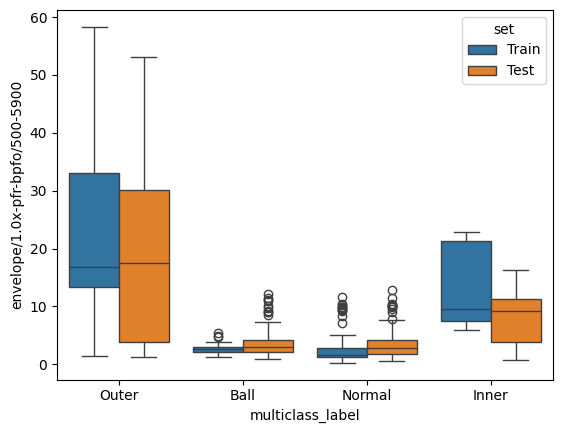

In [25]:
# make a boxplot of the features envelope/1.0x-pfr-bpfo/500-5900',  'envelope/1.0x-pfr-bpfi/500-5900',   'envelope/1.0x-pfr-bsf/500-5900' with multiclass_label as hue
import seaborn as sns
import matplotlib.pyplot as plt

features = ['envelope/1.0x-pfr-bpfo/500-5900', 'envelope/1.0x-pfr-bpfi/500-5900', 'envelope/1.0x-pfr-bsf/500-5900']
sns.boxplot(x='multiclass_label', y=features[0], data=df_ex, hue='set')
plt.show()

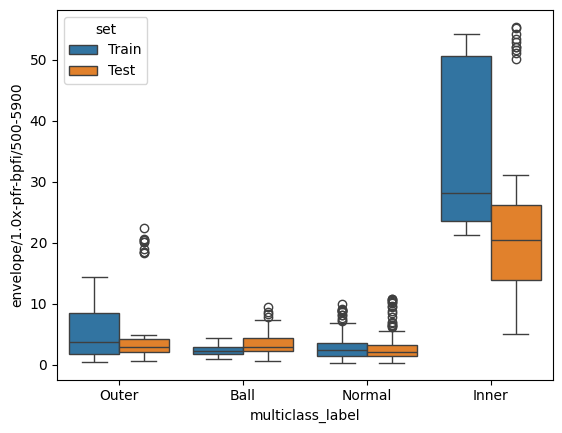

In [26]:
sns.boxplot(x='multiclass_label', y=features[1], data=df_ex, hue='set')
plt.show()

In [28]:
# create a interact from ipywidgets where i can choose a feature from pfrs list and create a boxplot with it:


import ipywidgets as widgets
from IPython.display import display
def plot_feature(feature):
    sns.boxplot(x='multiclass_label', y=feature, data=df_ex, hue='set')
    plt.show()

feature_selector = widgets.Dropdown(
    options=pfrs,
    description='Feature:',
    disabled=False,
)

widgets.interact(plot_feature, feature=feature_selector)

interactive(children=(Dropdown(description='Feature:', options=('envelope/1.0x-pfr-bpfo/500-5900', 'envelope/2…

<function __main__.plot_feature(feature)>

## SVM

In [99]:
from sklearn.svm import SVC

random_search = RandomizedSearchCV(
    estimator=MultiOutputClassifier(SVC(probability=True)),
    param_distributions={
        "estimator__C": loguniform(1e-3, 1e3),
        "estimator__gamma": ["scale", "auto"],
        "estimator__kernel": ["rbf"],
    },
    n_iter=250,
    cv=val_cvs,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1,
)

random_search.fit(X, y)

Fitting 6 folds for each of 250 candidates, totalling 1500 fits
[CV] END estimator__C=13.694723707952422, estimator__gamma=auto, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=13.694723707952422, estimator__gamma=auto, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=13.694723707952422, estimator__gamma=auto, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=13.694723707952422, estimator__gamma=auto, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=13.694723707952422, estimator__gamma=auto, estimator__kernel=rbf; total time=   0.1s
[CV] END estimator__C=1.5495156218194552, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.2s
[CV] END estimator__C=1.5495156218194552, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.2s
[CV] END estimator__C=1.5495156218194552, estimator__gamma=scale, estimator__kernel=rbf; total time=   0.2s
[CV] END estimator__C=1.5495156218194552, estimator__gamma=scale, estimator__

RandomizedSearchCV(cv=[([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43,
                         44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                         58, 59, ...],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35,
                         36, 37, 38, 39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, ...]),
                       ([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                         54, 55, 56, 57, 58, 59, 100, 101, 102, 103, 104, 105,
                         106, 107, 108, 109, ...],
                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...
                         103, 104, 105, 106, 107, 108, 109, 220, 221, 222, 223,
                         224, 225, 226, 227, 228, 229, ...])],
                   estimator=MultiOutputClassifier(estimator=SVC(probability=True)),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'estimator__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4d38b55510>,
                                        'estimator__gamma': ['scale', 'auto'],
                                        'estimator__kernel': ['rbf']},
                   scoring='roc_auc', verbose=2)

In [100]:
results = pd.DataFrame(random_search.cv_results_).sort_values(by="rank_test_score")

In [101]:
results.iloc[0]

mean_fit_time                                                        0.14737
std_fit_time                                                        0.011902
mean_score_time                                                     0.013798
std_score_time                                                      0.001015
param_estimator__C                                                170.451851
param_estimator__gamma                                                 scale
param_estimator__kernel                                                  rbf
params                     {'estimator__C': 170.45185082588512, 'estimato...
split0_test_score                                                   0.897374
split1_test_score                                                   0.822448
split2_test_score                                                   0.720975
split3_test_score                                                   0.847574
split4_test_score                                                   0.774062

In [102]:
best_params = results.iloc[0]["params"]

In [103]:
best_params.values()

dict_values([np.float64(170.45185082588512), 'scale', 'rbf'])

In [104]:
keys = []
for i in best_params.keys():
    keys.append(i.replace("estimator__", ""))

In [105]:
best_params = {k: i for (k,i) in zip(keys, best_params.values())}

In [106]:
best_params

{'C': np.float64(170.45185082588512), 'gamma': 'scale', 'kernel': 'rbf'}

In [107]:
len(cvs[0][1])

720

In [108]:
aucs = []
for cv in cvs:

    X_train = X.iloc[cv[0]]
    X_test = X.iloc[cv[1]]

    y_train = y.iloc[cv[0]]
    y_test = y.iloc[cv[1]]

    model = MultiOutputClassifier(SVC(random_state=42, **best_params, probability=True), n_jobs=-1)

    model.fit(X_train, y_train)
    y_probas = model.predict_proba(X_test)
    proba_outer = y_probas[1][:, 1]
    proba_inner = y_probas[0][:, 1]
    proba_ball = y_probas[2][:, 1]

    auroc_outer = roc_auc_score(y_test["outer"], proba_outer)
    auroc_inner = roc_auc_score(y_test["inner"], proba_inner)
    auroc_ball = roc_auc_score(y_test["ball"], proba_ball)

    macro_auc = np.mean([auroc_outer, auroc_inner, auroc_ball])
    print(f"Macro AUC: {macro_auc:.4f} | Outer AUC: {auroc_outer:.4f} | Inner AUC: {auroc_inner:.4f} | Ball AUC: {auroc_ball:.4f}")
    aucs.append([macro_auc, auroc_outer, auroc_inner, auroc_ball])


Macro AUC: 0.5883 | Outer AUC: 0.4173 | Inner AUC: 0.5569 | Ball AUC: 0.7907
Macro AUC: 0.5987 | Outer AUC: 0.4083 | Inner AUC: 0.6972 | Ball AUC: 0.6907
Macro AUC: 0.6938 | Outer AUC: 0.6837 | Inner AUC: 0.7179 | Ball AUC: 0.6797
Macro AUC: 0.7110 | Outer AUC: 0.6908 | Inner AUC: 0.7730 | Ball AUC: 0.6692
Macro AUC: 0.7248 | Outer AUC: 0.8536 | Inner AUC: 0.8872 | Ball AUC: 0.4336
Macro AUC: 0.6632 | Outer AUC: 0.8257 | Inner AUC: 0.6668 | Ball AUC: 0.4971
Macro AUC: 0.6385 | Outer AUC: 0.5408 | Inner AUC: 0.6803 | Ball AUC: 0.6944
Macro AUC: 0.7003 | Outer AUC: 0.8423 | Inner AUC: 0.5903 | Ball AUC: 0.6682
Macro AUC: 0.6435 | Outer AUC: 0.7032 | Inner AUC: 0.8052 | Ball AUC: 0.4221
Macro AUC: 0.6164 | Outer AUC: 0.6592 | Inner AUC: 0.6985 | Ball AUC: 0.4915
Macro AUC: 0.5836 | Outer AUC: 0.2340 | Inner AUC: 0.8031 | Ball AUC: 0.7136
Macro AUC: 0.5491 | Outer AUC: 0.3406 | Inner AUC: 0.9115 | Ball AUC: 0.3951
Macro AUC: 0.6483 | Outer AUC: 0.4993 | Inner AUC: 0.8104 | Ball AUC: 0.6351

In [109]:
macro_aucs = [i[0] for i in aucs] 
np.mean(macro_aucs), np.std(macro_aucs)

(np.float64(0.6581064360119047), np.float64(0.06969334966503257))